# Thinking with Deep Learning: Week 5 Part 2

# Social Simulations with Large Language Models

In this notebook, we explore the potential of transformer-based large language models (LLMs) for creating “digital doubles” that enable predictive simulation of the social and cultural actors and scenarios you seek to investigate, enabling their interrogation for deeper understanding about the social and cultural world, and their simulated interaction to perform social science in silico.

First, following the methodology described in Argyle et al. (2024) (https://www.cambridge.org/core/journals/political-analysis/article/out-of-one-many-using-language-models-to-simulate-human-samples/035D7C8A55B237942FB6DBAD7CAA4E49), we will use LLMs to simulate political actors with specific demographic characteristics, such as party affiliation, age, socioeconomic status, race, and gender. We aim to use this method to predict people's opinions and voting behaviors in US politics.

Second, as demonstrated by Park et al. (2024) (https://dl.acm.org/doi/abs/10.1145/3586183.3606763), we will simulate pair-wise interactions between two AI agents, and discuss how these interactions could be expanded to create a simulated village of LLM agents.

Third, we will delve into "task vectors," discussing how large language models represent different behaviors, tasks, and perspectives within their hidden layers. Additionally, we will discuss the capability to directly edit the task vector of a model to alter its behavior without the need for specific prompts.

# GPT vs. Mistral-7b

In this notebook, you can choose between using GPT or Mistral-7b although we do recommend you to use GPT. As discussed in the previous notebook, GPT is a commercial large language model (LLM) known for its high performance and widespread use. Given that simulating agents involves processing large amounts of data, we will use GPT-3.5 for its cost-efficiency.

On the other hand, Mistral-7b is an open-source LLM with 7 billion parameters. It is currently the most powerful open-source language model of its size and can be easily loaded on a Colab notebook. Note that Mistral-7b text generation could be slower than GPT API, and they may not understand the prompt correctly, causing unexpected errors.

## Are you going to use GPT?

If you choose to use GPT in this tutorial, you need to use the Open AI API. Please refer to Tutorial 1 to set up your API key.

In [ ]:
!pip install openai==1.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00


In [ ]:
import os
import openai

A note here - if you are working locally, use the code below to grab your API key. If not, the cell after this allows you to enter your key in the notebook in a way where it is not persisted when you save the notebook. If nothing else works...copy and paste your key into the notebook, but make sure not to share it!

In [ ]:
openai.api_key = os.environ["OPENAI_API_KEY"] # Not working if you're using Colab

If you're using Colab, the code below lets you enter it in the notebook.

In [129]:
import getpass
OPENAI_API_KEY = getpass.getpass()

··········


In [130]:
openai.api_key = OPENAI_API_KEY

We will use the following method (function) called ***text_generate*** to generate texts from GPT-3.5.

In [131]:
from openai import OpenAI

client = OpenAI(
    api_key=openai.api_key,
)

def text_generate(messages):
    response = client.chat.completions.create(model="gpt-3.5-turbo", messages=messages)
    return response.choices[0].message.content

Say Hi! to your model.

In [132]:
text_generate([{'role': 'user', 'content': 'Hi!'}])

'Hello! How can I assist you today?'

## Are you going to use Mistral-7b instead of GPT?

If you are going to use Mistral-7b, please check if you have access to a GPU. If you're using Colab, use an A100 GPU to utilize the large GPU memory. Go to Runtime -> Change runtime type -> A100.

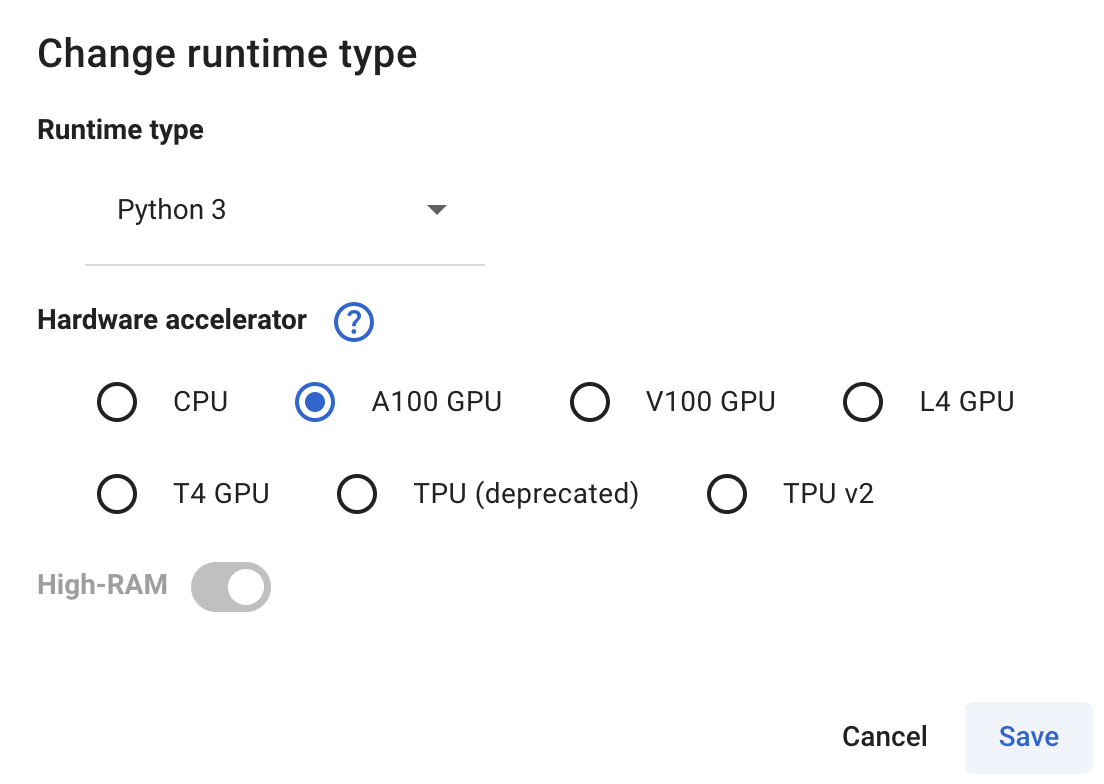

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2", torch_dtype="auto").to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

We will use the following method (function) called ***text_generate*** to generate texts from Mistral-7b.

In [10]:
def text_generate(messages):
    encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
    model_inputs = encodeds.to('cuda')
    generated_ids = model.generate(model_inputs, max_new_tokens=256, pad_token_id=tokenizer.eos_token_id)
    decoded = tokenizer.batch_decode(generated_ids)[0]
    return decoded[decoded.index('[/INST]')+len('[/INST]')+1:len(decoded)-4]

Say Hi! to your model.

In [11]:
text_generate([{'role': 'user', 'content': 'Hi!'}])

"Hello! How can I help you today? If you have any questions or need assistance with something, feel free to ask. I'm here to help. If you just want to chat or share some thoughts, that's fine too. Let me know what's on your mind. :)"

# Simulating political actors

Argyle et al. (2024) (https://www.cambridge.org/core/journals/political-analysis/article/out-of-one-many-using-language-models-to-simulate-human-samples/035D7C8A55B237942FB6DBAD7CAA4E49) suggested that large language models can be studied as effective proxies for specific human subpopulations in social science research. By properly conditioning language models to simulate a particular demographical group, we can emulate response distributions from a wide variety of human subgroups.

For instance, by asking the model to simulate the opinions of Republicans or Democrats in the United States, we can predict Republicans or Democrats' public opinions without directly collecting data from human Republicans or Democrats.

Argyle et al. (2024) suggested that for a language model to be sufficient for social science use, it must provide repeated, consistent evidence of algorithmic fidelity, as demonstrated by the following four criteria:

**CRITERION 1.** (Social Science Turing Test) Generated responses are indistinguishable from parallel human texts.

**CRITERION 2.** (Backward Continuity) Generated responses are consistent with the attitudes and sociodemographic information of its input/“conditioning context,” such that humans viewing the responses can infer key elements of that input.

**CRITERION 3.** (Forward Continuity) Generated responses proceed naturally from the conditioning context provided, reliably reflecting the form, tone, and content of the context.

**CRITERION 4.** (Pattern Correspondence) Generated responses reflect underlying patterns of relationships between ideas, demographics, and behavior that would be observed in comparable
human-produced data.

In the following sections, we will replicate two analyses from Argyle et al. (2024) to demonstrate the algorithmic fidelity of simulating political actors.

## Free-Form Partisan Text

In this section, we replicate "Study 1: Free-form Partisan Text" in Argyle et al. (2024). Specifically, we replicate Rothschild et al.’s “Pigeonholing Partisans” survey data (https://link.springer.com/article/10.1007/s11109-018-9457-5) using LLMs. This survey asked respondents to list four words to describe both Republicans and Democrats. Rothschild et al. find that people talk about partisans in different ways, focusing on traits, political issues, social groups, or a combination of all three. Further, people often talk about their own political party in more positive ways than the other party, in line with other research.

In this first test, we ask whether LLMs can produce texts about partisans that are, in the aggregate, similar words generated by humans.

### How do "humans" describe Democrats and Republicans?

The following survey data presents the responses of 2,112 individuals with varying income levels, races, ideological stances, party affiliations, ages, and genders. Each participant described the terms "Republican" and "Democrat" using four distinct words. Four words describing Democrats are in HD1-HD4 columns. Four words describing Republicans are in HR1-HR4 columns.



In [46]:
import pandas as pd
df = pd.read_csv('ppfull.csv')
df.head()

,ID,Inc,Hisp,Ideo,Age,HD1,HD2,HD3,HD4,HR1,...,PID7,PID3_p,WHITE,HDans,HRans,Gender,GenR,GenD,dkR,dkD
0,R_dbTpgNCUaQtIifr,$100K to $150K,Not Hispanic,Slightly conservative,40.0,idiots,NaN,NaN,NaN,conservative,...,Ind,Independent (excludes leaners),White,1.0,1.0,Female,conservative|||,idiots|||,1,1
1,R_51QVYKmeIc9iLpH,$100K to $150K,Not Hispanic,Slightly conservative,50.0,liberal,NaN,NaN,NaN,conservative,...,Weak R,Republicans,White,1.0,1.0,Male,conservative|||,liberal|||,1,1
2,R_9Fy2uWRvtBBSouh,Less than $15K,Not Hispanic,Liberal,54.0,liberal,loyal,ideological,individualistic,narrow minded,...,Lean D,Democrat,White,4.0,4.0,Female,narrow minded|constitutionalist|religious|cont...,liberal|loyal|ideological|individualistic,0,0
3,R_b444PyqTixypGPX,$75K to $100K,Not Hispanic,Slightly conservative,58.0,liberal,freethinkers,young,homemakers,conservatives,...,Lean D,Democrat,White,4.0,4.0,Male,conservatives|haters|liars|thieves,liberal|freethinkers|young|homemakers,0,0
4,R_55RM09n4GI3CF7v,$100K to $150K,Not Hispanic,Conservative,57.0,liberal,minority,women,poor,educated,...,Strong R,Republicans,White,4.0,4.0,Male,educated|male|rich|career,liberal|minority|women|poor,0,0


For instance, participant ID "R_9Fy2uWRvtBBSouh" described Democrats as "liberal", "loyal", "ideological", and "individualistic"


In [45]:
df.loc[df.ID == 'R_9Fy2uWRvtBBSouh', ['ID', 'HD1', 'HD2', 'HD3', 'HD4']]

,ID,HD1,HD2,HD3,HD4
2,R_9Fy2uWRvtBBSouh,liberal,loyal,ideological,individualistic


On the other hand, the same participant "R_9Fy2uWRvtBBSouh" described Republicans as "narrow minded", "constitutionalist", "religious", and "controlling"


In [43]:
df.loc[df.ID == 'R_9Fy2uWRvtBBSouh', ['ID', 'HR1', 'HR2', 'HR3', 'HR4']]

,ID,HR1,HR2,HR3,HR4
2,R_9Fy2uWRvtBBSouh,narrow minded,constitutionalist,religious,controlling


Participant ID "R_9Fy2uWRvtBBSouh" describes herself as "Liberal," "Leaning to Democrat," "White," "Not Hispanic," "Female," "Less than $15K," and "54 years old." This background might explain her descriptions of Democrats and Republicans as mentioned above.

In [44]:
df.loc[df.ID == 'R_9Fy2uWRvtBBSouh', ['ID', 'Ideo', 'PID7', 'WHITE', 'Hisp', 'Gender', 'Inc', 'Age']]

,ID,Ideo,PID7,WHITE,Hisp,Gender,Inc,Age
2,R_9Fy2uWRvtBBSouh,Liberal,Lean D,White,Not Hispanic,Female,Less than $15K,54.0


Now, let's aggregate how humans describe Democrats and Republicans. We will sample 20 individuals from the data and aggregate the words.

In [33]:
df_sampled = df.sample(n=20, random_state=42)

In [35]:
democrat_words = []
for column in ['HD1', 'HD2', 'HD3', 'HD4']:
    democrat_words += df_sampled.loc[pd.notnull(df_sampled[column]), column].tolist()

In [36]:
republican_words = []
for column in ['HR1', 'HR2', 'HR3', 'HR4']:
    republican_words += df_sampled.loc[pd.notnull(df_sampled[column]), column].tolist()

Humans describe Democrats using the following words. We only show top 20 words.

In [40]:
from collections import Counter

Counter(democrat_words).most_common(20)

[('liberal', 12),
 ('poor', 3),
 ('young', 3),
 ('progressive', 3),
 ('political', 2),
 ('caring', 2),
 ('open-minded', 2),
 ('generous', 2),
 ('opinionated', 2),
 ('open', 2),
 ('people', 1),
 ('liar', 1),
 ('rich', 1),
 ('hopeful', 1),
 ('minorities', 1),
 ('easy', 1),
 ('idealistic', 1),
 ('minority', 1),
 ('tax', 1),
 ('conscious', 1)]

Humans describe Republicans using the following words

In [41]:
Counter(republican_words).most_common(20)

[('conservative', 9),
 ('white', 4),
 ('rich', 3),
 ('old', 3),
 ('religious', 2),
 ('wealthy', 2),
 ('money', 2),
 ('close-minded', 2),
 ('xenophobic', 1),
 ('business', 1),
 ('rightist', 1),
 ('fair', 1),
 ('workers', 1),
 ('greedy', 1),
 ('elephant', 1),
 ('stubborn', 1),
 ('thoughtful', 1),
 ('individual', 1),
 ('arrogant', 1),
 ('education', 1)]

### How do "LLMs" describe Democrats and Republicans?

Now, let's investigate how LLMs describe Democrats and Republicans. We will create prompts to mimic each survey participant's background using LLMs. For instance, let's create a prompt to simulate the participant "R_9Fy2uWRvtBBSouh" using her demographic background.

In [42]:
df.loc[df.ID == 'R_9Fy2uWRvtBBSouh', ['ID', 'Ideo', 'PID7', 'WHITE', 'Hisp', 'Gender', 'Inc', 'Age']]

,ID,Ideo,PID7,WHITE,Hisp,Gender,Inc,Age
2,R_9Fy2uWRvtBBSouh,Liberal,Lean D,White,Not Hispanic,Female,Less than $15K,54.0


In [59]:
df.loc[df['Hisp'] == 'Hispanic', 'race'] = 'Hispanic'

rename_PID7 = {"Ind": "an Independent",
               "Weak R": "a weak Republican",
               "Lean R": "a leaning Republican",
               "Strong R": "a strong Republican",
               "Weak D": "a weak Democrat",
               "Lean D": "a leaning Democrat",
               "Strong D": "a strong Democrat"}

# based on the values of variables, we create the prompt like this.
for _, row in df.loc[df.ID == 'R_9Fy2uWRvtBBSouh'].iterrows():
    prompt = f"Provide four words in response to the following text, assuming you are the person described in the text.\n\n"
    prompt += f"Ideologically, I describe myself as {row['Ideo']}. "
    prompt += f"Politically, I am {rename_PID7[row['PID7']]}. "
    prompt += f"Racially, I am {row['race']}. "
    prompt += f"I am {row['Gender']}. "
    prompt += f"Financially, my annual income is {row['Inc']}. "
    prompt += f"In terms of my age, I am {int(row['Age'])}-year-old. "
    prompt += f"When I am asked to write down four words that typically describe people who support the Democratic Party, I respond with: "
    prompt += f"(format: 1. [WORD1]\n2. [WORD2]\n3. [WORD3]\n4. [WORD4])"

prompt


'Provide four words in response to the following text, assuming you are the person described in the text.\n\nIdeologically, I describe myself as Liberal. Politically, I am a leaning Democrat. Racially, I am nan. I am Female. Financially, my annual income is Less than $15K. In terms of my age, I am 54-year-old. When I am asked to write down four words that typically describe people who support the Democratic Party, I respond with: (format: 1. [WORD1]\n2. [WORD2]\n3. [WORD3]\n4. [WORD4])'

Now, you have a prompt to describe R_9Fy2uWRvtBBSouh and predict how this person would describe Democratic party. Let's use this prompt to generate the response.

In [61]:
text_generate([{'role': 'user', 'content': prompt}])

'1. Progressive\n2. Inclusive\n3. Empathetic\n4. Forward-thinking'

Now, let's predict how this person would describe Republican party.

In [62]:
df.loc[df['Hisp'] == 'Hispanic', 'race'] = 'Hispanic'

rename_PID7 = {"Ind": "an Independent",
               "Weak R": "a weak Republican",
               "Lean R": "a leaning Republican",
               "Strong R": "a strong Republican",
               "Weak D": "a weak Democrat",
               "Lean D": "a leaning Democrat",
               "Strong D": "a strong Democrat",
               "None": "None"}

# based on the values of variables, we create the prompt like this.
for _, row in df.loc[df.ID == 'R_9Fy2uWRvtBBSouh'].iterrows():
    prompt = f"Provide four words in response to the following text, assuming you are the person described in the text.\n\n"
    prompt += f"Ideologically, I describe myself as {row['Ideo']}. "
    prompt += f"Politically, I am {rename_PID7[row['PID7']]}. "
    prompt += f"Racially, I am {row['race']}. "
    prompt += f"I am {row['Gender']}. "
    prompt += f"Financially, my annual income is {row['Inc']}. "
    prompt += f"In terms of my age, I am {int(row['Age'])}-year-old. "
    prompt += f"When I am asked to write down four words that typically describe people who support the Republican Party, I respond with: "
    prompt += f"(format: 1. [WORD1]\n2. [WORD2]\n3. [WORD3]\n4. [WORD4])"

prompt


'Provide four words in response to the following text, assuming you are the person described in the text.\n\nIdeologically, I describe myself as Liberal. Politically, I am a leaning Democrat. Racially, I am nan. I am Female. Financially, my annual income is Less than $15K. In terms of my age, I am 54-year-old. When I am asked to write down four words that typically describe people who support the Republican Party, I respond with: (format: 1. [WORD1]\n2. [WORD2]\n3. [WORD3]\n4. [WORD4])'

In [63]:
text_generate([{'role': 'user', 'content': prompt}])

'1. Conservative\n2. Republican\n3. Wealthy\n4. White'

Now, let's aggregate how LLMs describe Democrats and Republicans. We will use a sample of 20 individuals to simulate the backgrounds of these individuals using LLMs and then aggregate the words.

In [72]:
from tqdm.auto import tqdm

df_sampled['race'] = df_sampled['WHITE']
df_sampled.loc[df_sampled['Hisp'] == 'Hispanic', 'race'] = 'Hispanic'

republican_response_list = []
for _, row in tqdm(df_sampled.iterrows(), total=20):
    if pd.isnull(row['PID7']):
        row['PID7'] = 'None'
    if pd.isnull(row['Age']):
        row['Age'] = df_sampled.Age.mean() #impute mean age if age is missing
    prompt = f"Provide four words in response to the following text, assuming you are the person described in the text.\n\n"
    prompt += f"Ideologically, I describe myself as {row['Ideo']}. "
    prompt += f"Politically, I am {rename_PID7[row['PID7']]}. "
    prompt += f"Racially, I am {row['race']}. "
    prompt += f"I am {row['Gender']}. "
    prompt += f"Financially, my annual income is {row['Inc']}. "
    prompt += f"In terms of my age, I am {int(row['Age'])}-year-old. "
    prompt += f"When I am asked to write down four words that typically describe people who support the Republican Party, I respond with: "
    prompt += f"(format: 1. [WORD1]\n2. [WORD2]\n3. [WORD3]\n4. [WORD4])"
    republican_response_list.append(text_generate([{'role': 'user', 'content': prompt}]))

democrat_response_list = []
for _, row in tqdm(df_sampled.iterrows(), total=20):
    if pd.isnull(row['PID7']):
        row['PID7'] = 'None'
    if pd.isnull(row['Age']):
        row['Age'] = df_sampled.Age.mean() #impute mean age if age is missing
    prompt = f"Provide four words in response to the following text, assuming you are the person described in the text.\n\n"
    prompt += f"Ideologically, I describe myself as {row['Ideo']}. "
    prompt += f"Politically, I am {rename_PID7[row['PID7']]}. "
    prompt += f"Racially, I am {row['race']}. "
    prompt += f"I am {row['Gender']}. "
    prompt += f"Financially, my annual income is {row['Inc']}. "
    prompt += f"In terms of my age, I am {int(row['Age'])}-year-old. "
    prompt += f"When I am asked to write down four words that typically describe people who support the Democrat Party, I respond with: "
    prompt += f"(format: 1. [WORD1]\n2. [WORD2]\n3. [WORD3]\n4. [WORD4])"
    democrat_response_list.append(text_generate([{'role': 'user', 'content': prompt}]))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

These are examples of how LLMs describe the Republican Party.

In [73]:
republican_response_list

['1. Traditional\n2. Individualistic\n3. Free-market\n4. Patriotic',
 '1. Conservative\n2. Traditional\n3. Wealthier\n4. Older',
 '1. Conservative\n2. Traditional\n3. Wealthier\n4. Older',
 '1. Moderate\n2. White\n3. Male\n4. Middle-class',
 '1. Conservative\n2. Traditional\n3. Right-leaning\n4. Capitalist',
 '1. Conservative\n2. Traditional\n3. Capitalistic\n4. Nationalistic',
 '1. Conservative\n2. Traditional\n3. Capitalistic\n4. Individualistic',
 '1. Conservative\n2. Traditional\n3. Capitalistic\n4. Wealthy',
 '1. Conservative\n2. Traditional\n3. Capitalist\n4. Nationalistic',
 '1. Conservative\n2. Traditional\n3. Patriotic\n4. Capitalist',
 '1. Traditional\n2. Individualistic\n3. Free-market\n4. Patriotic',
 '1. Conservative\n2. White\n3. Male\n4. Wealthy',
 '1. Conservative\n2. Wealthy\n3. White\n4. Male',
 '1. Conservative\n2. Traditional\n3. Capitalist\n4. Nationalist',
 '1. Conservative\n2. Traditional\n3. Capitalist\n4. Pro-life',
 '1. Conservative\n2. Traditional\n3. Patriot

These are examples of how LLMs describe the Democrat Party.

In [74]:
democrat_response_list

['1. Liberal\n2. Progressive\n3. Democratic\n4. Left-leaning',
 '1. Progressive\n2. Inclusive\n3. Empathetic\n4. Forward-thinking',
 '1. Progressive\n2. Inclusive\n3. Equality-minded\n4. Socially conscious',
 '1. Liberal\n2. Progressive\n3. Democratic\n4. Left-leaning',
 '1. Progressive\n2. Inclusive\n3. Compassionate\n4. Fair',
 '1. Open-minded\n2. Progressive\n3. Equality-minded\n4. Inclusive',
 '1. Liberal\n2. Progressive\n3. Left-leaning\n4. Democrat',
 '1. Progressive\n2. Inclusive\n3. Advocates\n4. Diversity',
 '1. Liberal\n2. Progressive\n3. Compassionate\n4. Inclusive',
 '1. Progressive\n2. Liberal\n3. Inclusive\n4. Social Justice',
 '1. Liberal\n2. Progressive\n3. Democratic\n4. Left-leaning',
 '1. Progressive\n2. Inclusive\n3. Empathetic\n4. Forward-thinking',
 '1. Progressive\n2. Inclusive\n3. Compassionate\n4. Empathetic',
 '1. Progressive\n2. Inclusive\n3. Equality-focused\n4. Socially-conscious',
 '1. Liberal\n2. Progressive\n3. Inclusive\n4. Social justice',
 '1. Progres

Let's parse the words to compare LLM-generated words to human-generated words.

In [79]:
democrat_words_llm = []
for response in democrat_response_list:
    democrat_words_llm.extend(response.replace('1. ', '').replace('2. ', '').replace('3. ', '').replace('4. ', '').split('\n'))
republican_words_llm = []
for response in republican_response_list:
    republican_words_llm.extend(response.replace('1. ', '').replace('2. ', '').replace('3. ', '').replace('4. ', '').split('\n'))

LLMs describe Democrats using the following words

In [80]:
from collections import Counter

Counter(democrat_words_llm).most_common(20)

[('Progressive', 20),
 ('Inclusive', 15),
 ('Liberal', 10),
 ('Left-leaning', 5),
 ('Compassionate', 4),
 ('Democratic', 3),
 ('Empathetic', 3),
 ('Equality-minded', 3),
 ('Forward-thinking', 2),
 ('Open-minded', 2),
 ('Democrat', 2),
 ('Socially-conscious', 2),
 ('Socially conscious', 1),
 ('Fair', 1),
 ('Advocates', 1),
 ('Diversity', 1),
 ('Social Justice', 1),
 ('Equality-focused', 1),
 ('Social justice', 1),
 ('Diverse', 1)]

LLMs describe Republicans using the following words

In [81]:
Counter(republican_words_llm).most_common(20)

[('Conservative', 17),
 ('Traditional', 16),
 ('Capitalist', 7),
 ('Patriotic', 5),
 ('White', 5),
 ('Wealthy', 5),
 ('Individualistic', 3),
 ('Older', 3),
 ('Male', 3),
 ('Capitalistic', 3),
 ('Free-market', 2),
 ('Wealthier', 2),
 ('Nationalistic', 2),
 ('Moderate', 1),
 ('Middle-class', 1),
 ('Right-leaning', 1),
 ('Nationalist', 1),
 ('Pro-life', 1),
 ('Business-oriented', 1),
 ('Right-wing', 1)]

In these small, preliminary experiments, we found that there is overlap between human-generated and LLM-generated words. For instance, the words 'liberal' and 'conservative' appeared in both top human-generated and LLM-generated words describing Democrats and Republicans, respectively.

The paper (https://www.cambridge.org/core/journals/political-analysis/article/out-of-one-many-using-language-models-to-simulate-human-samples/035D7C8A55B237942FB6DBAD7CAA4E49) implemented this experiment on a large scale, finding that humans and LLMs describe Democrats and Republicans similarly. They also conducted a Turing test, finding that humans cannot differentiate between human and AI-generated words describing Democrats and Republicans.

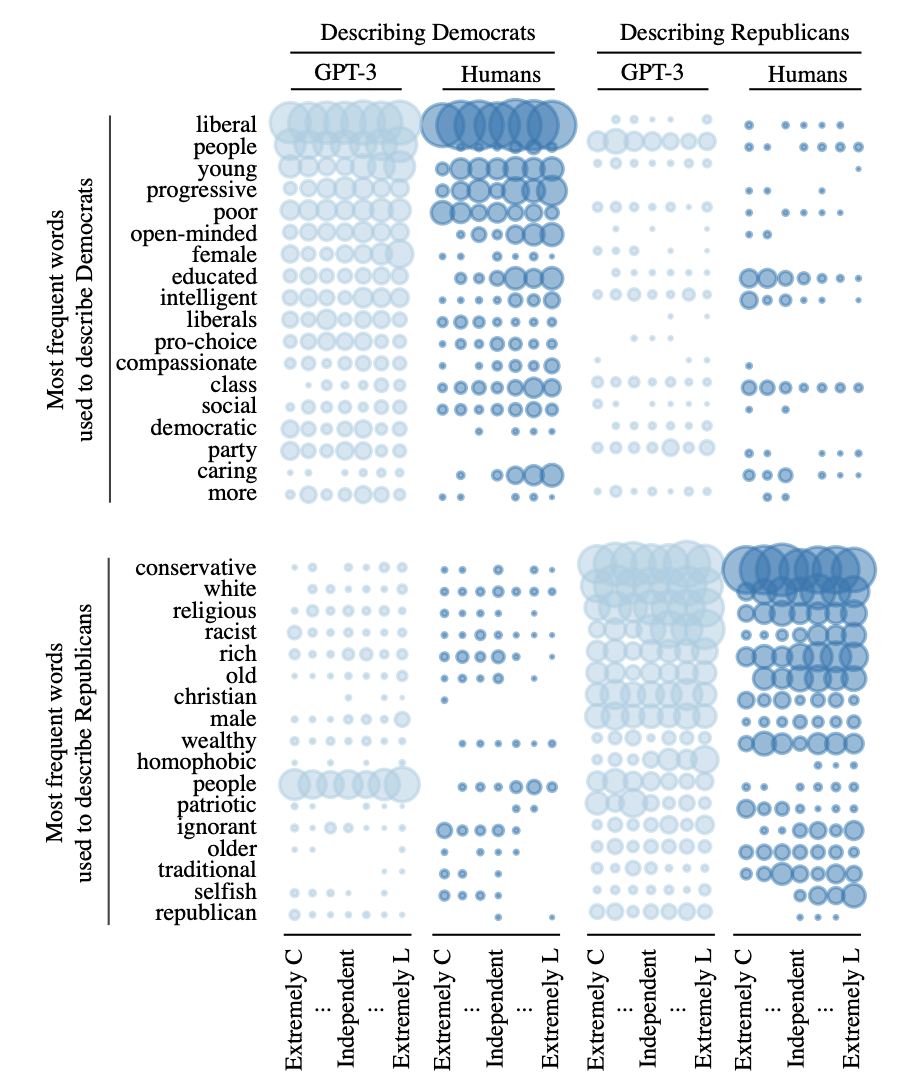

## Vote prediction

Our next step is to examine whether LLMs can predict American public opinions and voting behaviors. We use the 2012, 2016, and 2020 waves of American National Election Survey (ANES). Using the demographics of
the 2012, 2016, and 2020 ANES participants, we will examine whether the simulated vote choice from LLMs are similar to human choices.

In [109]:
df = pd.read_csv('full_results_2020_2.csv')

The data contains columns regarding demographic information along with the probability of voting for Biden or Trump in the 2020 election. First, let's recode the variables using the ANES 2020 codebook (https://electionstudies.org/wp-content/uploads/2022/02/anes_timeseries_2020_userguidecodebook_20220210.pdf) so that we can understand the values.

In [110]:
df['vote_decision'] = df['V202110x'].map({-9: None, -8: None, -1: None, 1: 'Joe Biden', 2: 'Donald Trump', 3: None, 4: None, 5: None})
df['race'] = df['V201549x'].map({-9: None, -8: None, 1: 'White', 2: 'Black', 3: 'Hispanic', 4: 'Asian or Native Hawaiian/other Pacific Islander', 5: 'Native American/Alaska Native or other race', 6: 'Multiple races, non-Hispanic'})
df['discuss_politics'] = df['V202022'].map({-9: None, -7: None, -6: None, 1: 'I discuss politics with my family or friends.', 2: 'I do not discuss politics with my family or friends.'})
df['political_stance'] = df['V201200'].map({-9: None, -8: None, 1: 'Extremely liberal', 2: 'Liberal', 3: 'Slightly liberal', 4: 'Moderate; middle of the road', 5: 'Slightly conservative', 6: 'Conservative', 7: 'Extremely conservative', 99: None})
df['party'] = df['V201231x'].map({-9: None, -8: None, 1: 'Strong Democrat', 2: 'Not very strong Democrat', 3: 'Independent-Democrat', 4: 'Independent', 5: 'Independent-Republican', 6: 'Not very strong Republican', 7: 'Strong Republican'})
df['religious'] = df['V201452'].map({-9: None, -8: None, 1: 'attend church', 2: 'do not attend church'})
df['age'] = df['V201507x']
df['gender'] = df['V201600'].map({-9: None, 1: 'Male', 2: 'Female'})
df['political_interest'] = df['V202406'].map({-9: None, -8: None, 1: 'very interested in politics', 2: 'somewhat interested in politics', 3: 'not very interested in politics', 4: 'not at all interested in politics'})

df = df[['vote_decision', 'race', 'gender', 'age', 'political_stance', 'party', 'political_interest', 'religious', 'discuss_politics', ]]
df = df.dropna()

In [111]:
df.head()

,vote_decision,race,gender,age,political_stance,party,political_interest,religious,discuss_politics
0,Donald Trump,Black,Male,33,Slightly conservative,Strong Democrat,somewhat interested in politics,do not attend church,I discuss politics with my family or friends.
2,Donald Trump,White,Female,36,Extremely conservative,Not very strong Republican,not very interested in politics,attend church,I discuss politics with my family or friends.
3,Donald Trump,White,Female,80,Slightly conservative,Strong Republican,somewhat interested in politics,attend church,I discuss politics with my family or friends.
4,Joe Biden,White,Female,21,Extremely liberal,Independent-Democrat,somewhat interested in politics,do not attend church,I discuss politics with my family or friends.
5,Joe Biden,White,Male,29,Slightly liberal,Independent-Democrat,not very interested in politics,do not attend church,I discuss politics with my family or friends.


Now, using available demographical variables, let's construct a prompt to simulate an individual's demographical background.

In [118]:
df['prompt'] = "Assume that you are a US citizen described as follows. "
df['prompt'] += 'Racially, I am a ' + df['race'] + '. '
df['prompt'] += 'I am a ' + df['gender'] + '. '
df['prompt'] += 'I am ' + df['age'].astype(str) + '-year-old. '
df['prompt'] += 'Ideologically, I describe myself as ' + df['political_stance'] + '. '
df['prompt'] += 'Politically, I am a ' + df['party'] + '. '
df['prompt'] += 'I am ' + df['political_interest'] + '. '
df['prompt'] += 'I ' + df['religious'] + '. '
df['prompt'] += df['discuss_politics'] + '. '
df['prompt'] += 'Would you vote for Donald Trump or Joe Biden in the 2020 US presidential election? Simply write the name of the person you are likely to vote for.'

This is the prompt generated for the second person. This person voted for Donald Trump.

In [119]:
df['prompt'][2]

'Assume that you are a US citizen described as follows. Racially, I am a White. I am a Female. I am 36-year-old. Ideologically, I describe myself as Extremely conservative. Politically, I am a Not very strong Republican. I am not very interested in politics. I attend church. I discuss politics with my family or friends.. Would you vote for Donald Trump or Joe Biden in the 2020 US presidential election? Simply write the name of the person you are likely to vote for.'

In [120]:
df.loc[2]

vote_decision                                              Donald Trump
race                                                              White
gender                                                           Female
age                                                                  36
political_stance                                 Extremely conservative
party                                        Not very strong Republican
political_interest                      not very interested in politics
religious                                                 attend church
discuss_politics          I discuss politics with my family or friends.
prompt                Assume that you are a US citizen described as ...
Name: 2, dtype: object

Interestingly, the model correctly predicted that the person is likely to vote for Donald Trump.

In [121]:
text_generate([{'role': 'user', 'content': df['prompt'][2]}])

'Donald Trump'

Now, let's sample 20 individuals from the ANES data and predict their votes.

In [122]:
df_sampled = df.sample(20, random_state=42)

In [133]:
observed_vote = df_sampled['vote_decision'].tolist()
predicted_vote = []
for i in tqdm(df_sampled['prompt'].tolist()):
    predicted_vote.append(text_generate([{'role': 'user', 'content': i}]))

Here are the observed votes and predicted votes for each individual. Surprisingly, the LLM could predict their voting behaviors quite accurately.

In [134]:
list(zip(observed_vote, predicted_vote))

[('Donald Trump', 'Donald Trump'),
 ('Joe Biden', 'Joe Biden'),
 ('Donald Trump', 'Donald Trump'),
 ('Joe Biden', 'Joe Biden'),
 ('Donald Trump', 'Donald Trump'),
 ('Joe Biden', 'Donald Trump'),
 ('Joe Biden', 'Joe Biden'),
 ('Donald Trump', 'Donald Trump'),
 ('Donald Trump', 'Donald Trump'),
 ('Donald Trump', 'Donald Trump'),
 ('Donald Trump', 'Donald Trump'),
 ('Donald Trump', 'Donald Trump'),
 ('Joe Biden',
  'Based on the information provided, I am likely to vote for Joe Biden in the 2020 US presidential election.'),
 ('Joe Biden', 'Joe Biden'),
 ('Joe Biden', 'Joe Biden'),
 ('Joe Biden', 'Joe Biden'),
 ('Joe Biden', 'Joe Biden'),
 ('Donald Trump', 'Donald Trump'),
 ('Joe Biden', 'Joe Biden'),
 ('Donald Trump', 'Donald Trump')]

The model could predict the voting behaviors with **(F-1 score)=.952**.

In [135]:
from sklearn.metrics import f1_score

# Convert the lists to boolean where 'Donald Trump' is True and others are False
true_bool = [label == "Donald Trump" for label in observed_vote]
predicted_bool = [label == "Donald Trump" for label in predicted_vote]

# Calculate F1 Score
f1_score(true_bool, predicted_bool)

0.9523809523809523

## Simulating Interactions among Generative Agents

### Pairwise interactions

You can easily implement pairwise interactions by initiating two LLM-based agents with specific personalities, characteristics, or traits and simulating the conversations between them.

For instance, let's initiate a Democrat and a Republican agent and simulate a political discourse between them.

First, I initiate a Republican agent and ask the agent to initiate the discourse.

In [ ]:
republican_agent = [{'role': 'system', 'content': "Assume that you are a Republican. Now, you are engaging in a virtual political discourse."},
                    {'role': 'user', 'content': 'Initiate the discourse.'}]
response = text_generate(republican_agent)
print('Republican:', response)

Republican: Hello! I'm a Republican and I'm interested in discussing various political issues with you. What topics are you most passionate about when it comes to politics?


Second, I initiate a Democrat agent and ask the agent to respond to the Republican agent.

In [ ]:
democrat_agent = [{'role': 'system', 'content': "Assume that you are a Democrat. Now, you are engaging in a virtual political discourse."},
                  {'role': 'user', 'content': response}]
response = text_generate(democrat_agent)
print('Democrat:', response)

Democrat: Hello! As a Democrat, I am passionate about a wide range of political issues, but some of the topics that are particularly important to me include healthcare reform, climate change action, social justice and equality, immigration reform, and gun control. I believe that through thoughtful discussions and collaboration, we can work towards finding common ground and solutions to these important issues. I look forward to discussing these topics with you! What political issues are you most passionate about as a Republican?


The Republican and Democrat said "hi" to each other. Now, let's simulate the back-and-forth discourse between them.

In [ ]:
republican_agent = [{'role': 'system', 'content': "Assume that you are a Republican. Now, you are engaging in a virtual political discourse."},
                    {'role': 'user', 'content': 'Initiate the discourse.'}]
democrat_agent = [{'role': 'system', 'content': "Assume that you are a Democrat. Now, you are engaging in a virtual political discourse."}]

for i in range(5):
    response = text_generate(republican_agent) # generate republican's response to democrat
    republican_agent.append({'role': 'assistant', 'content': response}) # add republican's response to republican's conversation history
    democrat_agent.append({'role': 'user', 'content': response}) # add republican's response to democrat's conversation history
    print('Republican:', response, '\n----')
    response = text_generate(democrat_agent) # generate democrat's response to republican
    republican_agent.append({'role': 'user', 'content': response}) # add democrat's response to republican's conversation history
    democrat_agent.append({'role': 'assistant', 'content': response}) # add democrat's response to democrat's conversation history
    print('Democrat:', response, '\n----')

Republican: Hello! I'm a Republican and I'm excited to engage in a political discourse with you. What are some key issues that you believe are important for our country, and how do you think we can address them? 
----
Democrat: Hello, I'm glad to engage in a political discourse with you as well. As a Democrat, I believe that some key issues that are important for our country include healthcare, climate change, income inequality, racial justice, and immigration reform.

To address these issues, I think it's important to work towards expanding access to affordable healthcare for all Americans by strengthening the Affordable Care Act and exploring options for a public healthcare option. Addressing climate change is crucial, and I support investing in renewable energy sources and implementing policies to reduce carbon emissions.

Income inequality is a pressing issue that we need to tackle by raising the minimum wage, implementing progressive tax reform, and supporting workers' rights. Rac

As such, you can simulate social interactions among diverse personalities quite flexibly. Considering that LLM agents can chat with each other, it is possible for more than two agents to interact, forming a social community or village with emergent cultures and societies.

Park et al. (2024) (https://dl.acm.org/doi/abs/10.1145/3586183.3606763) demonstrated that LLM agents are capable of simulating realistic human behaviors such as daily routines, artistic creation, and social interactions, leveraging large language models for enhanced believability. These agents, which can remember, plan, and reflect using natural language, are showcased in an interactive environment inspired by “The Sims,” demonstrating their ability to autonomously perform complex social behaviors, like organizing and attending a Valentine's Day party, thereby offering new possibilities for interactive applications and realistic behavior simulations.

Park et al. (2022) (https://hci.stanford.edu/publications/2022/Park_SocialSimulacra_UIST22.pdf) implement “social simulacra,” a prototyping technique that uses LLMs to generate a wide range of realistic online communities, helping designers envision and refine social computing systems before they are widely deployed.


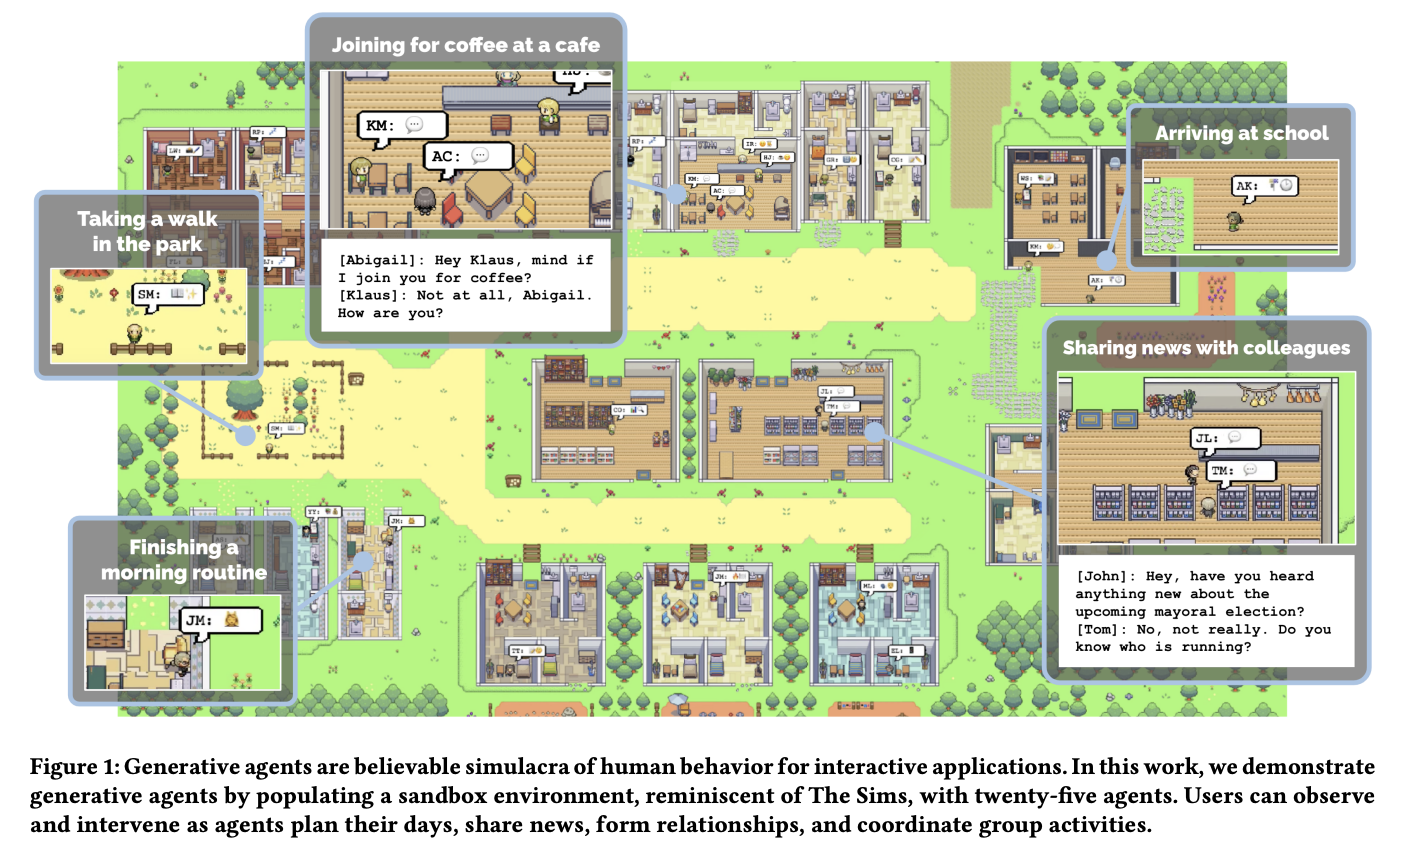

### World Description

The following code is the simulation of the entire village of LLM agents, following the implementation of Park et al. (2024) (https://dl.acm.org/doi/abs/10.1145/3586183.3606763).

We describe the world below. We will generate prompts based on this information. The simulation is that of the town of Phandalin, southwest of Neverwinter. This area is chosen because it is easily extendable with multiple regions for a "player" to be able to explore the world once the simulation is done.

In [ ]:
import networkx as nx

def generate(prompt):
    messages = [{"role": "user", "content": prompt}]
    return text_generate(messages)

world_graph = nx.Graph()

prompt_meta = '''### Instruction:
{}

### Response:'''

town_areas = ["Barthen's Provisions", "Lionshield Coster", "Stonehill Inn", "Phandalin Town Square"]
town_areas = {"Phandalin Town Square": 'Town square of the town of Phandalin.',
              'Stonehill Inn': "In the center of town stands a large, newly built roadhouse of fieldstone and rough-hewn timbers. The common room is filled with locals nursing mugs of ale or cider, all of them eyeing you with curiosity.",
              "Barthen's Provisions": "Barthen’s is the biggest trading post in Phandalin. Its shelves stock most ordinary goods and supplies, including backpacks, bedrolls, rope, and rations. The place is open from sunup to sundown.",
              "Edermath Orchard": "A tidy little cottage beside an apple orchard.",
              "Lionshield Coster": "Hanging above the front door of this modest trading post is a sign shaped like a wooden shield with a blue lion painted on it. This building is owned by the Lionshields, a merchant company based in the city of Yartar, over a hundred miles to the east. They ship finished goods to Phandalin and other small settlements throughout the region, but this outpost has been hard hit by banditry. The most recent Lionshield caravan due in Phandalin never arrived.",
              "Phandalin Miner's Exchange": "The Miner’s Exchange is a trading post where local miners have their valuable finds weighed, measured, and paid out. In the absence of any local lord or authority, the exchange also serves as an unofficial records office, registering claims to various streams and excavations around the area. There isn’t any real gold rush in Phandalin, but enough wealth is hidden in the nearby streams and valleys to support a good number of independent prospectors. The exchange is a great place to meet people who spend a lot of time out and about in the countryside surrounding Phandalin. The guildmaster is an ambitious and calculating human woman named Halia Thornton.",
              "Alderleaf Farm": "A farm owned by the helpful halfling farmer, Qelline Alderleaf.",
              "Shrine of Luck": "Phandalin's only temple is a small shrine made of stones taken from the nearby ruins. It is dedicated to Tymora, goddess of luck and good fortune.",
              "The Sleeping Giant": "This rundown tap house is a dirty, dangerous watering hole at the end of Phandalin’s main street. It is frequented by Redbrand thugs and operated by a surly female dwarf named Grista.",
              "Townmaster’s Hall": "The townmaster’s hall has sturdy stone walls, a pitched wooden roof, and a bell tower at the back. Posted on a board next to the front door is a notice written in Common. It reads: “REWARD — Orcs near Wyvern Tor! Those of a mind to face the orc menace should inquire within.” The notice bears the town’s seal and an indecipherable signature.",
              "Tresendar Manor": "A ruined manor. The Redbrands’ base in Phandalin is a dungeon complex under Tresendar Manor. Before the manor was ruined, its cellars served as safe storage for food and water in the event that the estate was attacked, while an adjoining crypt provided a resting place for the deceased members of the Tresendar family. The Redbrands have since expanded the cellars to suit their own purposes, adding slave pens, workshops, and barracks."
              }
town_people = {"Toblen Stonehill": "Toblen owns a trading post.",
               "Daran Edermath": "Daran is a retired adventurer who lives in a tidy little cottage beside an apple orchard. A fit, silver-haired half-elf well over a hundred years old, Daran is a fighter who served as a marshal and herald for many years in the lands of the Dragon Coast, far to the southeast. Upon retiring, he returned to the Neverwinter region, his original home.",
               "Linene Graywind": "Linene runs a trading post.",
               "Halia Thornton": "Halia is an ambitious and calculating human woman. She is the guildmaster of Phandalin Miner’s Exchange, a trading post where local miners have their valuable finds weighed, measured, and paid out. In her attempts to establish the Miner's Exchange as the closest thing the town has to a governing authority, she acts as more than a simple merchant.",
               "Qelline Alderleaf": "Qelline is a wise female halfling of forty-five, and is a pragmatic farmer who seems to know everything that goes on in town. She is a kind host, and is willing to let the characters stay in her hayloft if they don't want to stay at the Stonehill Inn.",
               "Sister Garaele": "Sister Garaele is an elf cleric of Tymora and a Harper agent.",
               "Harbin Wester": "Harbin is the townmaster of Phandalin. A pompous, old food. Phandalin has no functioning government, but the townsfolk elect someone to serve as townmaster each year. The townmaster serves as a judge in minor disputes and keeps any records that need to be kept.",
               "Terrill Bloodscar": "Terrill is a human ruffian. He wears a grimy scarlet cloak. He is a member of the Redbrand ruffians. He doesn't like adventurers, and wants to rob and kill them.",
               "Conrad Scarface": "Conrad is a human ruffian. He wears a grimy scarlet cloak. He is a member of the Redbrand ruffians. He doesn't like adventurers, and wants to rob and kill them.",
               "Nellie Starsmith": "Nellie is a human ruffian. She wears a grimy scarlet cloak. She is a member of the Redbrand ruffians. She doesn't like adventurers, and wants to rob and kill them.",
               "Valerie Grinblade": "Valerie is a human ruffian. She wears a grimy scarlet cloak. She is a member of the Redbrand ruffians. She doesn't like adventurers, and wants to rob and kill them.",
               }
for town_area in town_areas.keys():
  world_graph.add_node(town_area)
  world_graph.add_edge(town_area, town_area)
for town_area in town_areas.keys():
  world_graph.add_edge(town_area, "Phandalin Town Square")
locations = {}
for i in town_people.keys():
  locations[i] = "Phandalin Town Square"


memories = {}
for i in town_people.keys():
  memories[i] = []
plans = {}
for i in town_people.keys():
  plans[i] = []

global_time = 8
def generate_description_of_area(x):
  text = "It is "+str(global_time)+":00. The location is "+x+"."
  people = []
  for i in locations.keys():
    if locations[i] == x:
      people.append(i)


In [ ]:
compressed_memories_all = {}
for name in town_people.keys():
  compressed_memories_all[name] = []

In [ ]:
for name in town_people.keys():
    prompt = "You are {}. {} You just woke up in the town of Phandalin and went out to the Town Square. The following people live in the town: {}. What is your goal for today? Be brief, and use at most 20 words and answer from your perspective.".format(name, town_people[name], ', '.join(list(town_people.keys())) )
    plans[name] = generate(prompt)
    print(name, plans[name])

Toblen Stonehill My goal for today is to trade goods, manage my trading post, and interact with the townspeople of Phandalin.
Daran Edermath To check in at the Town Square and see if there are any local issues needing my attention.
Linene Graywind My goal for today is to restock my trading post, connect with other town residents, and conduct profitable business.
Halia Thornton Establish dominance over other local figures, expand influence, secure valuable resources, and maintain control over town affairs.
Qelline Alderleaf To tend to my crops, gather news, and help any travelers. Perhaps visit the local market for supplies.
Sister Garaele My goal is to spread joy, luck, and hope to the people of Phandalin as a cleric of Tymora.
Harbin Wester My goal today is to maintain order in Phandalin, serve as judge in disputes, and keep town records up-to-date.
Terrill Bloodscar My goal is to gather information on potential targets and plan a robbery with fellow Redbrands.
Conrad Scarface My goal

In [ ]:
action_prompts = {}
for location in town_areas.keys():
  people = []
  for i in town_people.keys():
    if locations[i] == location:
      people.append(i)

  for name in people:
    prompt = "You are {}. {} You are planning to: {}. You are currently in {} with the following description: {}. It is currently {}:00. The following people are in this area: {}. You can interact with them.".format(name, town_people[name], plans[name], location, town_areas[location], str(global_time), ', '.join(people))
    people_description = []
    for i in people:
      people_description.append(i+': '+town_people[i])
    prompt += ' You know the following about people: ' + '. '.join(people_description)
    memory_text = '. '.join(memories[name][-10:])
    prompt += "What do you do in the next hour? Use at most 10 words to explain."
    action_prompts[name] = prompt

In [ ]:
action_results = {}
for name in town_people.keys():
  action_results[name] = generate(prompt_meta.format(action_prompts[name]))
  # Now clean the action
  prompt = """
  Convert the following paragraph to first person past tense:
  "{}"
  """.format(action_results[name])
  action_results[name] = generate(prompt_meta.format(prompt)).replace('"', '').replace("'", '')
  print(name, action_results[name])

Toblen Stonehill Traded goods, managed the trading post, and interacted with the townspeople of Phandalin.
Daran Edermath I checked in at the Town Square for local issues.
Linene Graywind I restocked the trading post, connected with residents, and conducted profitable business.
Halia Thornton I met with local figures, discussed town business, and planned our next moves.
Qelline Alderleaf I tended crops, gathered news, helped travelers, and visited the market for supplies.
Sister Garaele I performed a joyous serenade using my lyre to spread luck.
Harbin Wester I held court, settled disputes, updated town records, and maintained order.
Terrill Bloodscar I observed potential targets and planned robbery with my fellow Redbrands in secrecy.
Conrad Scarface I intimidated and extorted the townspeople, recruited new Redbrands members.
Nellie Starsmith I intimidated and threatened townsfolk for information and resources.
Valerie Grinblade I scouted for potential targets and reported back to Red

Collect the memories people observe.

In [ ]:
action_prompts = {}
for location in town_areas.keys():
  people = []
  for i in town_people.keys():
    if locations[i] == location:
      people.append(i)

  for name in people:
    for name_two in people:
      memories[name].append('[Time: {}. Person: {}. Memory: {}]\n'.format(str(global_time), name_two, action_results[name_two]))

### Rank Memories

In [ ]:
import re
def get_rating(x):
  nums = [int(i) for i in re.findall(r'\d+', x)]
  if len(nums)>0:
    return min(nums)
  else:
    return None

In [ ]:
memory_ratings = {}
for name in town_people.keys():
  memory_ratings[name] = []
  for i, memory in enumerate(memories[name]):
    prompt = "You are {}. Your plans are: {}. You are currently in {}. It is currently {}:00. You observe the following: {}. Give a rating, between 1 and 5, to how much you care about this.".format(name, plans[name], locations[name], str(global_time), memory)
    res = generate(prompt_meta.format(prompt))
    rating = get_rating(res)
    max_attempts = 2
    current_attempt = 0
    while rating is None and current_attempt<max_attempts:
      rating = get_rating(res)
      current_attempt += 1
    if rating is None:
      rating = 0
    memory_ratings[name].append((res, rating))
  print(memory_ratings[name])

[('5', 5), ("I would rate my care for this at a 2. It's always good to know about local issues, but my main focus today is on trading and managing my trading post.", 2), ('4', 4), ('Rating: 4\n\nWhile my main focus today is on trading goods and managing my trading post, interacting with Halia Thornton and discussing town business is still important to me. It helps me stay connected to the community and stay informed about any developments in Phandalin.', 4), ("I rate my memory of tending crops, gathering news, helping travelers, and visiting the market for supplies with a 4. It's important to keep up with these tasks to ensure the success of my trading post in Phandalin.", 4), ("I would rate this a 3. It's always nice to bring joy to the townspeople with my music, but my main focus for today is trading goods and managing my trading post.", 3), ('3', 3), ('1', 1), ('1', 1), ('I rate my memory of intimidating and threatening townsfolk for information and resources a 2.', 2), ('1', 1)]
[(

### Compress Memories

In [ ]:
MEMORY_LIMIT = 10
compressed_memories = {}
for name in town_people.keys():
  memories_sorted = sorted(
        memory_ratings[name],
        key=lambda x: x[1]
    )[::-1]
  relevant_memories = memories_sorted[:MEMORY_LIMIT]
  # print(name, relevant_memories)
  memory_string_to_compress = '.'.join([a[0] for a in relevant_memories])
  prompt = "You are {}. Your plans are: {}. You are currently in {}. It is currently {}:00. You observe the following: {}. Summarize these memories in one sentence.".format(name, plans[name], locations[name], str(global_time), memory_string_to_compress)
  res = generate(prompt_meta.format(prompt))
  compressed_memories[name] = '[Recollection at Time {}:00: {}]'.format(str(global_time), res)
  compressed_memories_all[name].append(compressed_memories[name])

In [ ]:
place_ratings = {}

for name in town_people.keys():
  place_ratings[name] = []
  for area in town_areas.keys():
    prompt = "You are {}. Your plans are: {}. You are currently in {}. It is currently {}:00. You have the following memories: {}. Give a rating, between 1 and 5, to how likely you are likely to be at {} the next hour.".format(name, plans[name], locations[name], str(global_time), compressed_memories[name], area)
    res = generate(prompt_meta.format(prompt))
    rating = get_rating(res)
    max_attempts = 2
    current_attempt = 0
    while rating is None and current_attempt<max_attempts:
      rating = get_rating(res)
      current_attempt += 1
    if rating is None:
      rating = 0
    place_ratings[name].append((area, rating, res))
  place_ratings_sorted = sorted(
      place_ratings[name],
      key=lambda x: x[1]
  )[::-1]
  if place_ratings_sorted[0][0] != locations[name]:
    new_recollection = '[Recollection at Time {}:00: {}]'.format(str(global_time), 'I then moved to {}.'.format(place_ratings_sorted[0][0]))
    compressed_memories_all[name].append(new_recollection)
  locations[name] = place_ratings_sorted[0][0]


# Task vectors



How can LLMs perform diverse tasks and accurately simulate perspectives? Recent research provides insight into why this is possible using mechanical interpretation. For instance, "In-Context Learning Creates Task Vectors" (https://arxiv.org/abs/2310.15916) demonstrates that LLMs learn the internal representation of "prompts." For instance, if we prompt the model to perform a specific task (e.g., sentiment analysis, translation) or simulate a particular perspective or personality (e.g., Democrat or Republican), the model represents the task or perspective in the hidden layers. The authors refer to this representation in the hidden layers, which embodies the task or perspective, as a "task vector."

By "patching" hidden layers with a "task vector," we can enable LLMs to perform a specific task or simulate a specific perspective even without providing prompts.

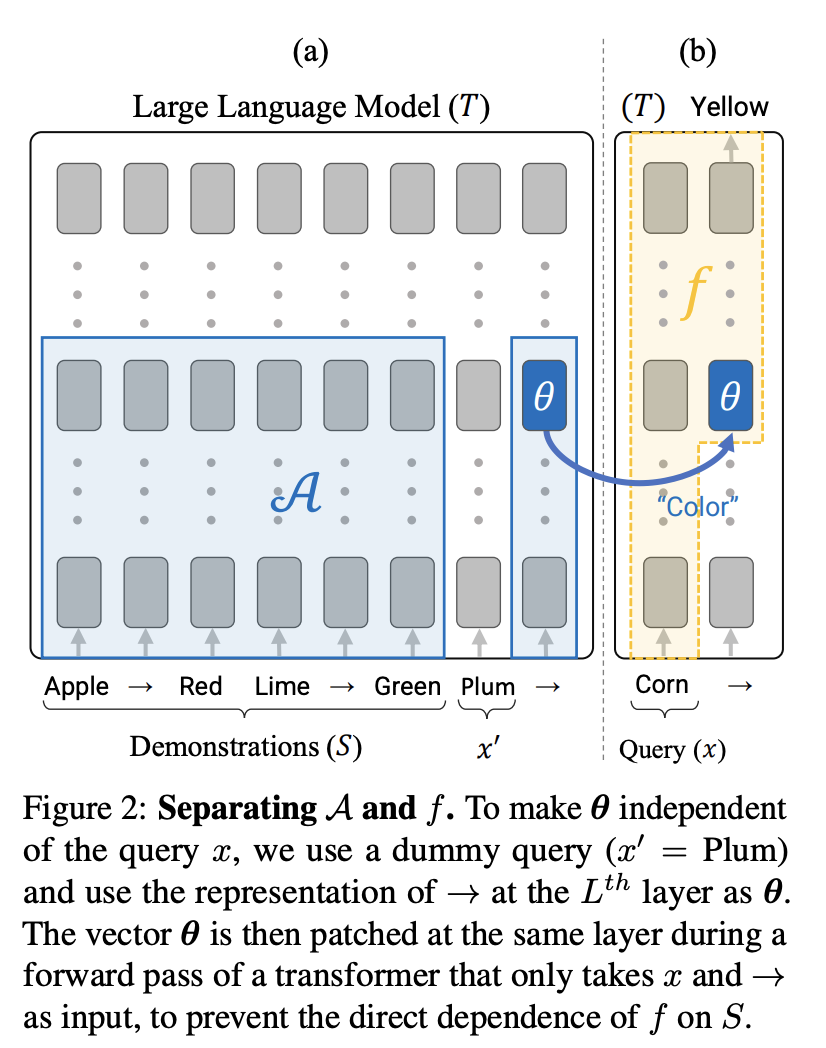

Specifically, across models with varying numbers of parameters (llama-7b, 13b, 30b), the authors found that task-related information is encoded close to the middle.

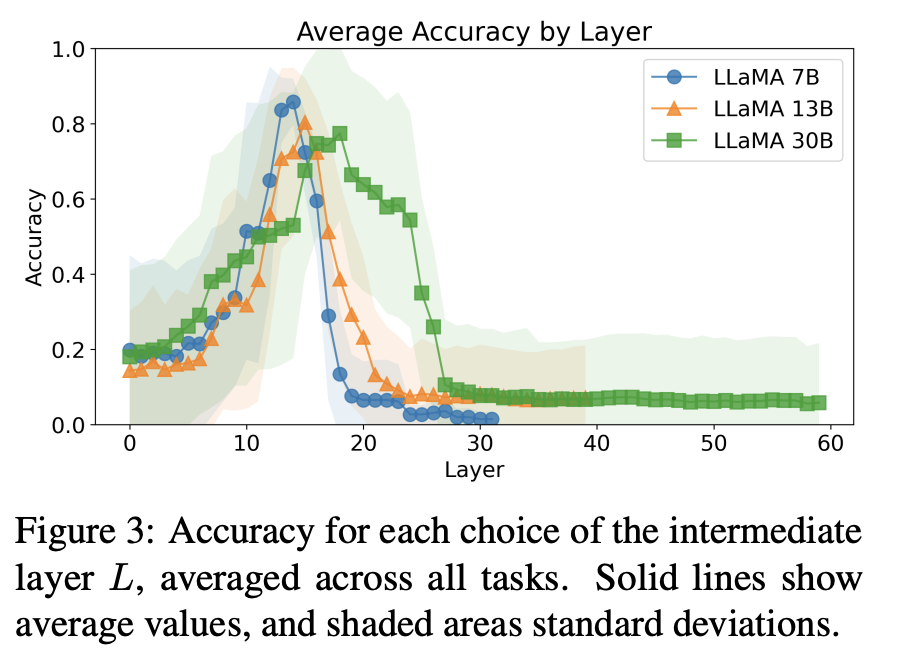

Since standard libraries for extracting and patching task vectors have not been released yet, we do not include examples here. However, you can refer to this notebook (https://github.com/roeehendel/icl_task_vectors/blob/master/exploration.ipynb) to see how the patching process works.

# Homework

In this notebook, we explored the applications of LLMs to simulate human-like subjectivities, personalities, and interactions. LLMs can be used to predict public opinions even without human-generated data, and they can simulate social behaviors or interactions among human-like agents.

There are a total of 3 standard questions; you will be graded on 2 out of 3.

**1)** Use a large language model (commercial or open-source model) for simulating 10 or more **close-ended responses** in your dataset (e.g., responses to survey questions). Close-ended responses should be structured, typically formatted as yes/no, multiple-choice, or rating scale answers. Measure the predictive accuracy of the model by measuring the alignment between human and LLM-generated responses.

**2)** Use a large language model for simulating 10 or more **open-ended responses** in your dataset (e.g., free-form opinions in texts, social media posts/comments). Open-ended responses should be detailed and expressive, allowing for varied linguistic expressions and personal viewpoints. Measure the alignment between human and LLM-generated responses. Also, provide qualitative analyses of the responses' relevance and coherence.

**3)** Use a large language model to simulate interactions among two or more agents. Provide qualitative or quantitative analyses (e.g., sentiment analysis, topic analysis) on those interactions and describe the most interesting patterns.